## Introduction

L'objet de ce projet est de modéliser le phénomène dit du mouvement rétrograde de Mars. Ce phénomène est le demi-tour apparent de la trajectoire de Mars par rapport à la voûte céleste, vu depuis la Terre.
Pour ce faire, nous allons modéliser les trajectoires de la Terre et de Mars et vérifier que la longitude apparente de Mars vue de la Terre, que nous calculerons, est raisonnablement proche des observations.

### Résolution du problème

Nous approximons les trajectoires de la Terre et de Mars comme des trajectoires circulaires uniformes, ce qui est raisonnablement proche de leurs orbites elliptiques à faible excentricité. Nous postulons que les deux planètes sont animées d'un mouvement circulaire uniforme dans un référentiel galiléen.
Les équations horaires de ces trajectoires dans le référentiel héliocentrique sont :
- $x(t) = R cos(wt + phi)$ 
- $y(t) = R sin(wt + phi)$

avec $R$ le rayon de la trajectoire, $w$ la période de rotation et $phi$ la phase à l'origine, c'est-à-dire l'angle avec l'axe (Ox) dans lequel pointe la direction des vecteurs positions des planètes.
Cela nous permet de positionner la Terre et Mars dans le repère héliocentrique à tout moment t. Nous pourrons ensuite en déduire les coordonnées de Mars dans le référentiel géocentrique à tout moment t et calculer sa longitude apparente vue de la Terre par la fonction arctangente.


In [1]:
# Importation des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import des données dans une dataframe
df_data = pd.read_csv('DataMars.csv', comment = '#')

#Vérification de l'intégrité de la DataFrame
df_data.head(10)

,Target,Date,Longitude (d:m:s),Longitude (decimal),Latitude (d:m:s),Latitude (decimal)
0,Mars,2015-03-01,6 41 13.6229,6.687117,-00 29 17.9130,-0.488309
1,Mars,2015-03-02,7 27 2.2465,7.450624,-00 28 35.5370,-0.476538
2,Mars,2015-03-03,8 12 48.4061,8.213446,-00 27 53.1443,-0.464762
3,Mars,2015-03-04,8 58 32.0880,8.975580,-00 27 10.7400,-0.452983
4,Mars,2015-03-05,9 44 13.2819,9.737023,-00 26 28.3298,-0.441203
5,Mars,2015-03-06,10 29 51.9805,10.497772,-00 25 45.9195,-0.429422
6,Mars,2015-03-07,11 15 28.1792,11.257828,-00 25 3.5151,-0.417643
7,Mars,2015-03-08,12 1 1.8757,12.017188,-00 24 21.1229,-0.405867
8,Mars,2015-03-09,12 46 33.0690,12.775852,-00 23 38.7494,-0.394097
9,Mars,2015-03-10,13 32 1.7594,13.533822,-00 22 56.4008,-0.382334


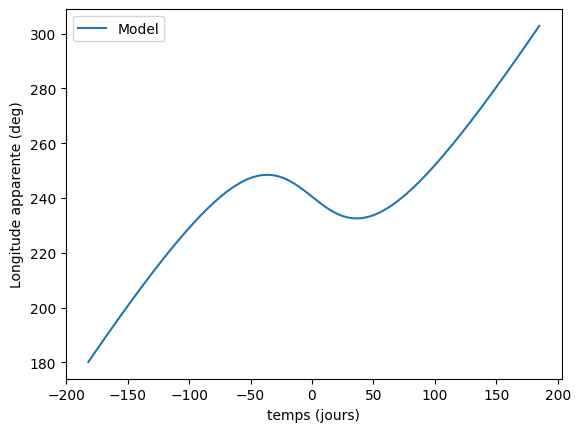

In [6]:
# Paramètres de la discrétisation
temps_initial = -182 # jour
temps_final = 185 # jour
pas_temps = 1 # jour

# Création du tableau temps
intervalle = temps_final - temps_initial
num_points = int(intervalle / pas_temps) + 1 # nombre d'éléments
temps = np.linspace(temps_initial, temps_final, num_points)

# Paramètres de la modélisation
R_terre = 1 # Rayon de l'orbite (u.a)
R_mars = 1.52371 # Rayon de l'orbite (u.a)
T_terre = 365.256 # Période de révolution (jours)
T_mars = 686.885 # Période de révolution (jours)
phi_0 = (240.5 / 360) * (2 * np.pi) # Phase à l'origine (radians)

#Génération des positions de la Terre dans le repère héliocentrique
omega_terre = (2 * np.pi / T_terre) * temps
x_terre = R_terre * np.cos(omega_terre + phi_0)
y_terre = R_terre * np.sin(omega_terre + phi_0)

#Génération des positions de Mars dans le repère héliocentrique
omega_mars = (2 * np.pi / T_mars) * temps
x_mars = R_mars * np.cos(omega_mars + phi_0)
y_mars = R_mars * np.sin(omega_mars + phi_0)

#Calcul des coordonnées de Mars dans le repère géocentrique
x_mars_geo = x_mars - x_terre
y_mars_geo = y_mars - y_terre

#Calcul de la longitude apparente de Mars depuis la Terre
longitude_app = np.arctan2(y_mars_geo, x_mars_geo)
longitude_app_deg = (longitude_app * 180 / np.pi) + 360

df_positions = pd.DataFrame(np.array([x_terre, y_terre, x_mars, y_mars, x_mars_geo, y_mars_geo]).T, index = temps, columns = ['x_terre', 'y_terre', 'x_mars', 'y_mars', 'x_mars_geo', 'y_mars_geo'])
df_longitude = pd.DataFrame(data = longitude_app_deg, index = temps, columns = ['longitude apparente'])

# Représentation graphique du mouvement
plt.plot(temps, longitude_app_deg)

# Style
plt.xlabel("temps (jours)")
plt.ylabel("Longitude apparente (deg)")
plt.legend(['Model'])
plt.show()


### Discussion des résultats

Le graphe ci-dessus représente la longitude apparente de Mars dans notre modèle en fonction du temps. Nous avons pris pour origine du temps le centre de la boucle, pour lequel les vecteurs positions de la Terre et de Mars sont alignés.

Nous voyons que la longitude apparente de Mars augmente en fonction du temps, puis diminue et augmente à nouveau. Ce résultat est cohérent avec la forme générale de la trajectoire de Mars dans le ciel.

Nous allons maintenant comparer notre modèle aux données mesurées.

In [7]:
#Ajout d'une colonne Date de type datetime a la dataframe du modèle
date_reference = np.datetime64('2016-05-25')
dates = date_reference + np.array(temps, dtype='timedelta64[D]')
df_longitude['Date'] = dates

In [9]:
# Selection des données
df_data_filtered = df_data.copy()
df_longitude_filtered = df_longitude.copy()

#Ajout d'une colonne Date en format Datetime à la dataframe de données
df_data_filtered['Date_datetime'] = pd.to_datetime(df_data_filtered['Date'], format='%Y-%m-%d')

#Filtrage des dataframes sur une plage de date pour comparaison
df_data_filtered = df_data_filtered[(df_data_filtered['Date_datetime'] >= np.datetime64('2016-01-01')) & (df_data_filtered['Date_datetime'] <= np.datetime64('2016-11-25'))]
df_longitude_filtered = df_longitude_filtered[(df_longitude_filtered['Date'] >= np.datetime64('2016-01-01')) & (df_longitude_filtered['Date'] <= np.datetime64('2016-11-25'))]


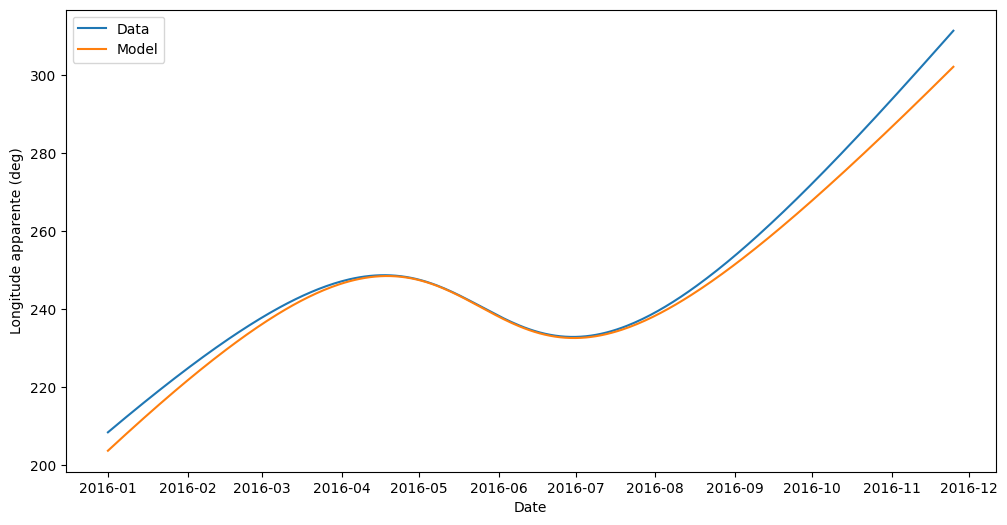

In [10]:
# Représentation graphique du mouvement
plt.figure(figsize=(12, 6))
plt.plot(df_data_filtered['Date_datetime'], df_data_filtered["Longitude (decimal)"])
plt.plot(df_longitude_filtered['Date'], df_longitude_filtered['longitude apparente'])

# Mise en forme du graphe
plt.xlabel("Date")
plt.ylabel("Longitude apparente (deg)")
plt.legend(['Data', 'Model'])
plt.show()

### Comparaison des résulats aux données

En comparant le résultat de notre modélisation aux données, nous remarquons que notre modélisation épouse la forme générale de la longitude apparente de Mars en fonction du temps. La correspondance est particulièrement bonne pour le mouvement dit "rétrograde", où la longitude de Mars diminue avant de reprendre sa tendance originale.
Notre modélisation s'éloigne des données lorsque nous nous éloignons du centre de la boucle.

Ceci semble indiquer que la modélisation en trajectoire circulaire uniforme est bonne en première approximation, mais devient moins précise avec le temps.

Ce résultat est cohérent avec la première loi de Kepler, qui stipule que les orbites des planètes sont des ellipses et non des cercles.

## Conclusion

Nous avons modélisé les trajectoires de la Terre et de Mars comme des trajectoires circulaires uniformes dans le référentiel héliocentrique pour expliquer le phénomène du mouvement rétrograde de Mars. Cette modélisation représente correctement ce phénomène, bien que sa précision diminue lorsqu'on s'éloigne de l'origine des temps. Ceci semble confirmer que les orbites ne sont pas des orbites circulaires, bien que cette approximation soit assez bonne localement.
Pour améliorer notre modèle, nous devrions paramétrer les équations du mouvement comme des trajectoires respectant les lois de Kepler, c'est-à-dire des ellipses dont les équations de mouvement respectent la loi des aires.

